In [1]:
#Bayesian statistics working code - not using c as a variable parameter

In [2]:
#importing
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt 
import pandas as pd
from astropy.stats import sigma_clip
from astropy.modeling import models,fitting
from scipy.ndimage import uniform_filter1d
from scipy.stats import norm
from scipy.special import voigt_profile
from scipy import signal
from scipy.signal import correlate
from PyAstronomy import pyasl
from scipy.optimize import curve_fit
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.constants import c
import astropy.io.fits as fits
from astropy.units import dimensionless_unscaled
from lmfit.models import LinearModel, GaussianModel, VoigtModel, PolynomialModel
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import glob
import fnmatch
import os
from astropy.timeseries import LombScargle
from plotnine import *
import traceback
import sys
import linecache
import textwrap
import re
import emcee
import corner
import tqdm

""" 
plt.rcParams['axes.linewidth'] = 1.25
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.25
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.25

default_settings = {
    'font.size': 16,
    'axes.linewidth': 0.8,
    'xtick.major.size': 3.5,
    'xtick.major.width': 1,
    'ytick.major.size': 3.5,
    'ytick.major.width': 1
}


initial_settings = {
    'font.size': 22,
    'axes.linewidth': 1.25,
    'xtick.major.size': 5,
    'xtick.major.width': 1.25,
    'ytick.major.size': 5,
    'ytick.major.width': 1.25
}
plt.rcParams.update(default_settings)
"""

" \nplt.rcParams['axes.linewidth'] = 1.25\nplt.rcParams['xtick.major.size'] = 5\nplt.rcParams['xtick.major.width'] = 1.25\nplt.rcParams['ytick.major.size'] = 5\nplt.rcParams['ytick.major.width'] = 1.25\n\ndefault_settings = {\n    'font.size': 16,\n    'axes.linewidth': 0.8,\n    'xtick.major.size': 3.5,\n    'xtick.major.width': 1,\n    'ytick.major.size': 3.5,\n    'ytick.major.width': 1\n}\n\n\ninitial_settings = {\n    'font.size': 22,\n    'axes.linewidth': 1.25,\n    'xtick.major.size': 5,\n    'xtick.major.width': 1.25,\n    'ytick.major.size': 5,\n    'ytick.major.width': 1.25\n}\nplt.rcParams.update(default_settings)\n"

In [3]:
#salt read in data
def Get_Wavelength_Flux_File(filename) :
    # Get the wavelength and flux from a MIDAS pipeline file
    hdulist = fits.open(filename)
    header = hdulist[0].header
    date_obs = header.get('DATE-OBS', None)
    time_obs = header.get('TIME-OBS',None)
    time = Time(str(date_obs) + 'T' + str(time_obs), format='fits')
    #time = Time(date_obs,format = "fits")
    
    flux = hdulist[0].data # flux in counts 
    
    CRVAL1 = hdulist[0].header['CRVAL1'] # Coordinate at reference pixel
    CRPIX1 = hdulist[0].header['CRPIX1'] # Reference pixel
    CDELT1 = hdulist[0].header['CDELT1'] # Coordinate increase per pixel
    HEL_COR = hdulist[0].header['HEL_COR'] # Heliocentric correction
    OBJECT = str(header.get("OBJECT", None))
    
    # Need to use the info above to make the wavelength axis
    wavelength = np.zeros(len(flux))
    print(f"The reference pixel in timefile: {time} is {CRPIX1}")
    for i in range(len(wavelength)) :
        #heliocentric correction
        wavelength[i] = (CRVAL1 + CDELT1*i) + (HEL_COR/299792 )*(CRVAL1 + CDELT1*i) - (CRPIX1*CDELT1)
        #wavelength[i] = (CRVAL1 + CDELT1*i)
    
    hdulist.close()	

    return wavelength, flux, time, OBJECT

In [4]:
#line dictionaries: Name, position(A), present?, log gf
#if you want to add a line to be used in the model, change the corresponding line in the dictionary to True instead of False
p_lines = []
spec_lines = []

#pollutant lines
p_lines.append(("CaII_3933", 3933.663, False)) #only use for MIKE data
p_lines.append(("CaII_4226",4226.727, False)) #good
p_lines.append(("FeII_4923",4923.927, False)) #can't use, crosses over with interorder
p_lines.append(("FeII_5018",5018.440, False))#not there
p_lines.append(("FeII_5169",5169.033, False)) #this one gives an error when trying to fit it
p_lines.append(("SiII_5041",5041.024, False)) #don't use this
p_lines.append(("SiII_5055",5055.984, True)) #This one is good use it
p_lines.append(("SiII_5957",5957.560, False))
p_lines.append(("SiII_5978",5978.930, False))
p_lines.append(("SiII_6347",6347.100, False)) #these two are quite strong in WD1929+012
p_lines.append(("SiII_6371",6371.360, False)) #
p_lines.append(("MgI_5172",5172.683, False))
p_lines.append(("MgI_5183",5183.602, False))
p_lines.append(("MgII_4481",4481.130,True)) #strong magnesium line
p_lines.append(("MgII_4481_2",4481.327, False))
p_lines.append(("MgII_4481",4481.180,False)) #weighted combination of mg_4481 lines

p_lines.append(("MgII_7877",7877.054, False)) 
p_lines.append(("MgII_7896",7896.366, False)) #definitely not present
p_lines.append(("OI_7771",7771.944, False)) #definitely not present
#hydrogen lines
p_lines.append(("H_4860",4860.680, False))
p_lines.append(("H_4860_2",4860.968, False))#This one gives better values
p_lines.append(("H_4860_2",4860.968, False))#Weighted combo
p_lines.append(("H_4340",4340.472,False)) #present
p_lines.append(("H_6563",6562.79 ,False)) #not present in the 2020 spectra?
#pick the spectral lines present in this white dwarf

for i in p_lines:
    if i[2] == True:
        spec_lines.append(i)

b_lines = []
r_lines = []
for i in spec_lines:
    if i[1] <= 5550:
        #370 - 555 nm
        b_lines.append(i)
    else:
        #555 - 890 nm
        r_lines.append(i)

#Now define the sky lines that we will use to find the stability corrections from the instrument variability

sky_lines = []
sky_lines.append(("OI_5577",5577.340))
sky_lines.append(("OI_6300",6300.304))
sky_lines.append(("OI_6364",6363.776))
#sky_lines.append(("H2O_7392"))
#sky_lines.append(("H2O_8365"))


In [5]:
#calculate errors - faster

def calculate_error(data):
    window_size = int(500)
    # Use a rolling window approach for efficient calculation of standard deviation
    #least mean squared method
    rolling_std = np.sqrt(np.convolve(data**2, np.ones(window_size) / window_size, mode='valid') - np.convolve(data, np.ones(window_size) / window_size, mode='valid')**2)
    
    # Extend the result to match the original length of the data
    pad_width = window_size // 2
    errors = np.pad(rolling_std, (pad_width, pad_width), mode='edge')
    #print(len(errors),len(data))
    errorsv = np.nan_to_num(errors)
    #print(np.mean(errorsv))
    return errorsv[:len(data)]


In [6]:
def poly_fit(gwav,gdata):
    poly_model = PolynomialModel(degree=7)
    params = poly_model.guess(gdata, x=gwav)
    poly_result = poly_model.fit(gdata, params, x=gwav)
    print(poly_result.params['c0'],poly_result.params['c1'],poly_result.params['c2'],poly_result.params['c3'],poly_result.params['c4'])
    
    #find the individual polynomial best fit
    c0 = poly_result.params['c0'].value
    c1 = poly_result.params['c1'].value
    c2 = poly_result.params['c2'].value
    c3 = poly_result.params["c3"].value
    c4 = poly_result.params["c4"].value
    c5 = poly_result.params["c5"].value
    c6 = poly_result.params["c6"].value
    c7 = poly_result.params["c7"].value
    
    p_result = c0 + c1 * gwav + c2 * gwav**2 + c3 * gwav**3 + c4 * gwav**4 + c5 * gwav**5 + c6 * gwav**6 + c7 * gwav**7

    plt.figure()
    plt.plot(gwav, p_result, color='green', linewidth=1)
    plt.plot(gwav, gdata, color='blue', linewidth=0.5)
    
    plt.show()
    return p_result

In [7]:
#function to pick the files that we want and make dictionaries of them

def pick_files_by_patterns(folder_path, start_patterns, end_patterns):
   
    matching_files = []

    # Ensure the folder path is valid
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return matching_files

    for folder_name in os.listdir(folder_path):
        fp = os.path.join(folder_path, folder_name,"product/")

        # List all files in the folder
        try:
            all_files = os.listdir(fp)
        except FileNotFoundError:
            continue
        except NotADirectoryError:
            continue

        # Filter files based on start patterns
        #for start_pattern in start_patterns:
        #   matching_files.extend(fnmatch.filter(all_files, start_pattern + '*'))

        # Filter files based on end patterns
        #for end_pattern in end_patterns:
         #   matching_files.extend(fnmatch.filter(all_files, '*' + end_pattern))
        for file in all_files:
            if file.startswith(start_patterns) and file.endswith(end_patterns):
                matching_files.append(os.path.join(fp, file))

    return matching_files


def mike_pick_files_by_patterns(folder_path, start_patterns, end_patterns):
    matching_files = []
    # Ensure the folder path is valid
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory.")
        return matching_files
    try:
        for file_name in os.listdir(folder_path):
            matching_files.append(os.path.join(folder_path, file_name))
    except FileNotFoundError:
        # Handle the case where the folder doesn't exist
        print(f"The folder '{folder_path}' does not exist.")
        return None
    
    # Return the list of matching files
    return matching_files

# Example usage:

#This is where we pick the folder path and the name of the file that we want
#Need to adjust this so that it is more clear
star = "WD1929+012"
SALT_folder_path = "/data/wdplanetary/omri/Data/WD1929+012/"
MIKE_blue_folder_path = "/data/wdplanetary/laura/MIKE/Data/WD1929+011/blue/"
MIKE_red_folder_path = "/data/wdplanetary/laura/MIKE/Data/WD1929+011/red/"


blue_start = ("mbgphH")
red_start =  ("mbgphR")
end_patterns = ("u2wm.fits")  #End pattern for the object fiber
sky_end_patterns = ("u1wm.fits") #End pattern for the sky fiber
merged_end_patterns = ("uwm.fits") #end pattern for the reduced fiber
mike_start = ("gal")
mike_end = (".fits")

#Creating file directory for the blue and red channels separately
b_files = pick_files_by_patterns(SALT_folder_path, blue_start, end_patterns)
merged_b_files = pick_files_by_patterns(SALT_folder_path, blue_start, merged_end_patterns)
r_files = pick_files_by_patterns(SALT_folder_path, red_start, end_patterns)
sky_r_files = pick_files_by_patterns(SALT_folder_path, red_start, sky_end_patterns)
mike_b_files = mike_pick_files_by_patterns(MIKE_blue_folder_path, mike_start,mike_end)
mike_r_files = mike_pick_files_by_patterns(MIKE_red_folder_path, mike_start,mike_end)

b_files.sort()
r_files.sort()
sky_r_files.sort()
mike_b_files.sort()
mike_r_files.sort()
bad_date = ['/data/wdplanetary/omri/Data/WD1929+012/2019-1-SCI-008.20190513',
            '/data/wdplanetary/omri/Data/WD1929+012/2020-1-SCI-043.20200531',
            '/data/wdplanetary/omri/Data/WD1929+012/2018-1-SCI-043.20180605',
            '/data/wdplanetary/omri/Data/WD1929+012/2019-2-SCI-049.20200824',
            '/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170813/product/mbgphH20170813003'
            ]

b_files = [f for f in b_files if not any(f.startswith(start) for start in bad_date)]
r_files = [f for f in r_files if not any(f.startswith(start) for start in bad_date)] 
sky_r_files = [f for f in sky_r_files if not any(f.startswith(start) for start in bad_date)] 
merged_b_files = [f for f in merged_b_files if not any(f.startswith(start) for start in bad_date)]


  0%|          | 16/5000 [00:00<01:09, 71.89it/s]

100%|██████████| 5000/5000 [00:50<00:00, 98.90it/s] 


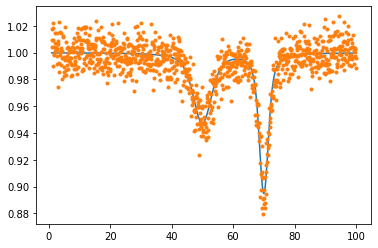

In [13]:
#This is the synthetic data code
#redone code from before that works? 
l = np.linspace(1,100,1000)
c = [20, 40]

def f(l, theta):
    Delta = theta[0]
    s = theta[1::3]
    g = theta[2::3]
    d = theta[3::3]
    return 1 + np.sum([-di* voigt_profile(l-(ci+Delta), si, gi) for ci, si, gi, di in zip(c, s,g, d)], axis=0)

np.random.seed(0)

rv = 30
sigma = 0.01
s1 = 2
g1 = 2
d1 = 0.5
s2 = 1
g2 = 1
d2 = 0.5
theta = [rv, s1,g1, d1, s2,g2, d2]
dist = norm(f(l, theta), sigma)
D = dist.rvs()

plt.plot(l, f(l,theta), '-')
plt.plot(l, D, '.')
""" 
def loglikelihood(theta):
    sigma = theta[-1]
    return norm(f(l, theta[:-1]), sigma).logpdf(D).sum()
 """
n = len(c)
#nDims = 3*n + 2

smin = 0
smax = 10
gmin = 0
gmax = 10
dmin = 0
dmax = 1
sigma_min = 0
sigma_max = 1
Delta_min = 0
Delta_max = 60

prior_min = np.array([Delta_min] + [smin,gmin, dmin]*n + [sigma_min])
prior_max = np.array([Delta_max] + [smax,gmax, dmax]*n + [sigma_max])

paramnames = [[('Delta', r'\Delta')]] + [[(f'w{i}', f'w_{i}'), (f'd{i}',f'd_{i}')] for i in range(n)] + [[('sigma', r'\sigma')]]
paramnames = [item for sublist in paramnames for item in sublist]

def log_likelihood(theta, l, D):
    sigma = theta[-1]
    residual = D - f(l, theta[:-1])
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the log prior function
def log_prior(theta):
    total_log_prior = 0
    Delta = theta[0]
    s_values = theta[1::3]
    g_values = theta[2::3]
    d_values = theta[3::3]
    if not (Delta_min < Delta < Delta_max):
        return -np.inf
    for s,g, d in zip(s_values,g_values, d_values):
        if not (smin < s < smax) or not (gmin < g < gmax) or not (dmin < d < dmax):
            return -np.inf
    if not (sigma_min < theta[-1] < sigma_max):
        return -np.inf
    #prior_logpdf = np.sum(norm.logpdf(theta[1], loc = s1,scale = 0.1))
    #total_log_prior += prior_logpdf
    return total_log_prior

# Define the log posterior function
def log_probability(theta, l, D):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, l, D)

from pyDOE import lhs
import corner
import tqdm

# Initialize walker positions using Latin hypercube sampling
""" 
ndim = 3 * n + 2  # Assuming n is defined elsewhere
nwalkers = 3*ndim
bounds = np.array([prior_min, prior_max]).T  # Define bounds for each parameter
lhs_samples = lhs(ndim, samples=nwalkers)
pos = bounds[:, 0] + lhs_samples * (bounds[:, 1] - bounds[:, 0])
 """

pos = np.array(theta) + 1e-2 * np.random.randn(3*len(theta), len(theta))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(l,D))

# Run the sampler
nsteps = 5000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain()#discard=100, thin=15, flat=True)


[30, 2, 2, 0.5, 1, 1, 0.5]


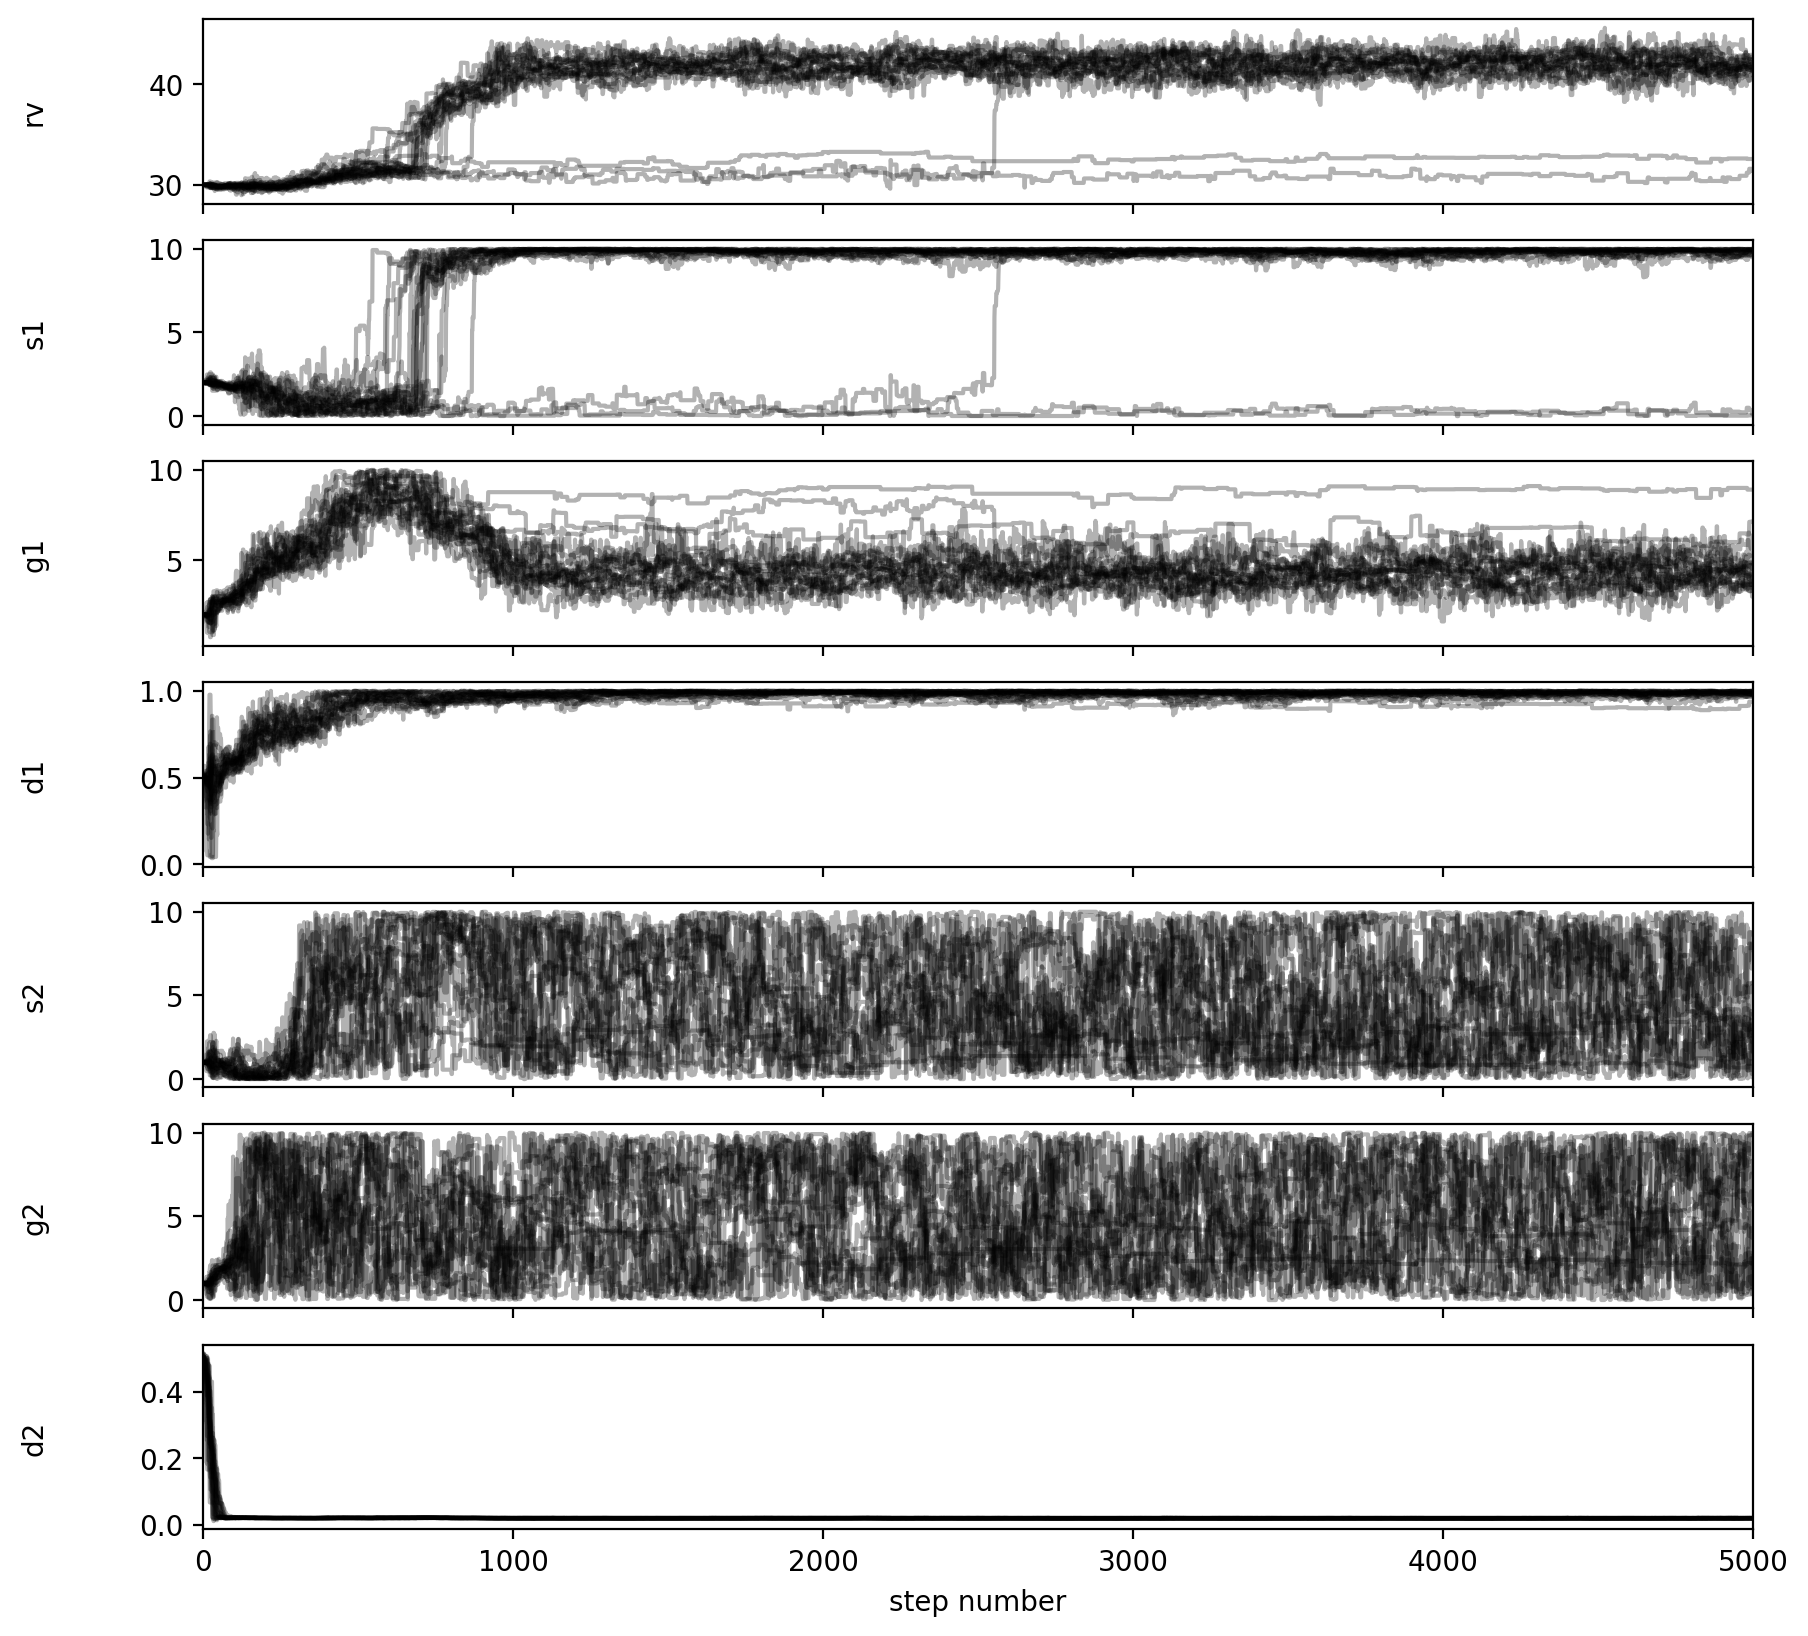

[40.38179725 41.82222119 42.89239509]
[[4.03817973e+01 9.46298869e+00 3.57929616e+00 9.66007453e-01
  1.36835896e+00 1.62709329e+00 1.84168078e-02]
 [4.18222212e+01 9.82951636e+00 4.41113500e+00 9.87691287e-01
  4.30973124e+00 4.58831414e+00 1.88490250e-02]
 [4.28923951e+01 9.95828475e+00 5.62323191e+00 9.97255859e-01
  8.12108709e+00 8.18399712e+00 1.94746861e-02]]


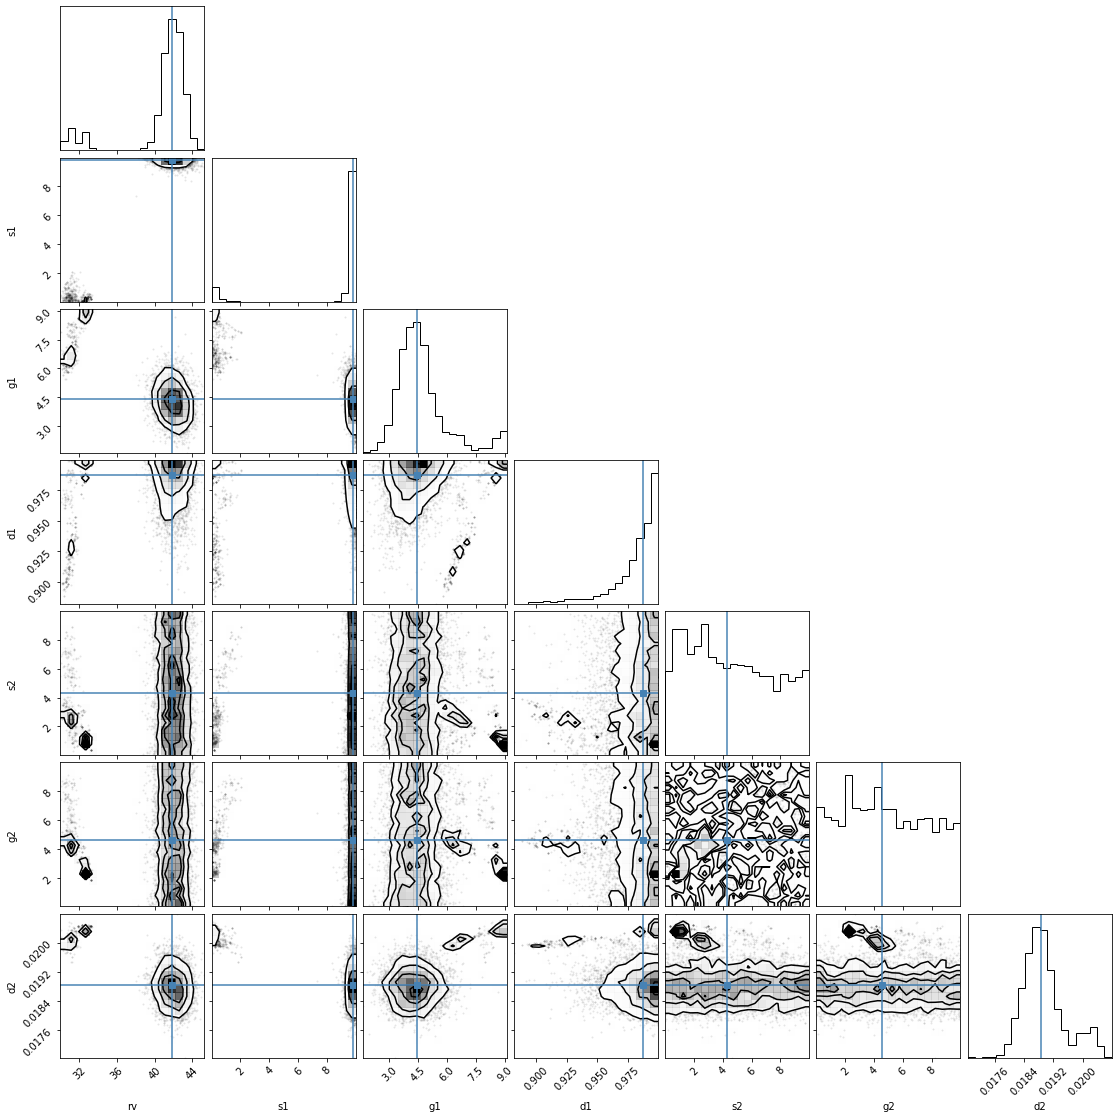

In [14]:
#synthetic data plot 
print(theta)
# Plot the traces
fig, axes = plt.subplots((len(theta)), figsize=(10, 10), sharex=True,dpi = 200)
labels = ["rv","s1", "g1","d1","s2", "g2","d2"]
for i in range((len(theta))):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

# Flatten the samples
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
percentiles = np.percentile(flat_samples, [16, 50, 84], axis=0)  # This gives the 16th, 50th (median), and 84th percentiles
print(percentiles[:,0])
print(percentiles)

# Compute the medians of the parameter samples
rv,s1,g1,d1,s2,g2,d2 = np.median(flat_samples, axis=0)
#print(rv,w1,c1,w2,c2,sigma)


fig = corner.corner(
    flat_samples, labels=labels,truths=[rv, s1,g1, d1, s2,g2, d2],dpi = 200)

The reference pixel in timefile: 2017-07-14T21:38:23.304 is 1.0
<Parameter 'c0', value=-474548.344031728 +/- 127, bounds=[-inf:inf]> <Parameter 'c1', value=712.5222533502528 +/- 0.132, bounds=[-inf:inf]> <Parameter 'c2', value=-0.4579587920489541 +/- 4.36e-05, bounds=[-inf:inf]> <Parameter 'c3', value=0.0001633322326876904 +/- nan, bounds=[-inf:inf]> <Parameter 'c4', value=-3.491098809906462e-08 +/- nan, bounds=[-inf:inf]>


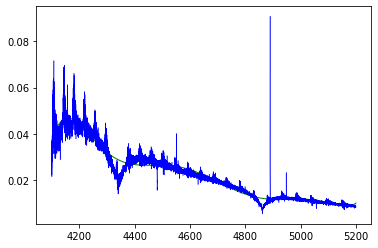

number of lines: 2
---------
the starting values are[36, 0.6, 0.6, 0.6, 0.6, 0.1, 0.1, 0.0, 0.0]
---------
[36, 0.6, 0.6, 0.6, 0.6, 0.1, 0.1, 0.0, 0.0]
36.0
sigmas of fit  = [0.6, 0.6, 0.1, 0.0]
gammas = [0.6, 0.6, 0.1, 0.0]
depth = [0.6, 0.1, 0.0]
[36, 0.6, 0.6, 0.6, 0.6, 0.1, 0.1, 0.0, 0.0]
36.0
sigmas of fit  = [0.6, 0.6, 0.1, 0.0]
gammas = [0.6, 0.6, 0.1, 0.0]
depth = [0.6, 0.1, 0.0]
[36, 0.6, 0.6, 0.6, 0.6, 0.1, 0.1, 0.0, 0.0]
36.0
sigmas of fit  = [0.6, 0.6, 0.1, 0.0]
gammas = [0.6, 0.6, 0.1, 0.0]
depth = [0.6, 0.1, 0.0]


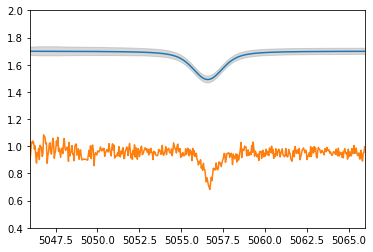

[36, 0.6, 0.6, 0.6, 0.6, 0.1, 0.1, 0.0, 0.0]
36.0
sigmas of fit  = [0.6, 0.6, 0.1, 0.0]
gammas = [0.6, 0.6, 0.1, 0.0]
depth = [0.6, 0.1, 0.0]
[36, 0.6, 0.6, 0.6, 0.6, 0.1, 0.1, 0.0, 0.0]
36.0
sigmas of fit  = [0.6, 0.6, 0.1, 0.0]
gammas = [0.6, 0.6, 0.1, 0.0]
depth = [0.6, 0.1, 0.0]
[36, 0.6, 0.6, 0.6, 0.6, 0.1, 0.1, 0.0, 0.0]
36.0
sigmas of fit  = [0.6, 0.6, 0.1, 0.0]
gammas = [0.6, 0.6, 0.1, 0.0]
depth = [0.6, 0.1, 0.0]


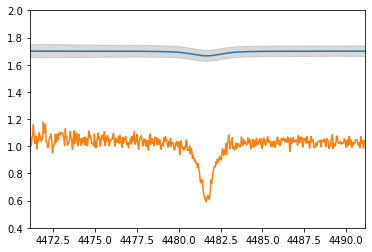

In [10]:
#Now apply for real data


wav,flux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170714/product/mbgphH201707140017_u2wm.fits")
#rwav,rflux,t,star = Get_Wavelength_Flux_File("/data/wdplanetary/omri/Data/WD1929+012/2017-1-SCI-031.20170711/product/mbgphR201707110020_u2wm.fits")
#wav = np.concatenate((bwav,rwav))
#flux = np.concatenate((bflux,rflux))
#lower bound of window
u_loc = np.searchsorted(wav, 5200) #5200
closest_value = wav[max(0, u_loc-1)]
u_bound = np.where(wav == closest_value)
u_bound = int(u_bound[0])
#find the lower bound of the window
l_loc = np.searchsorted(wav, 4100) #4100
closest_value = wav[max(0, l_loc-1)]
l_bound = np.where(wav == closest_value)
l_bound = int(l_bound[0])
y = flux[l_bound:u_bound]
l = wav[l_bound:u_bound]
p_result = poly_fit(l,y)
D = y/p_result
sigma = calculate_error(D)/2



c_priors_list = []
lines = ([i[1] for i in b_lines])
c1 = np.array(lines)

n = len(c1)
print(f"number of lines: {n}")
#initial values for each line 
rv = 36
#sigma = 0.03
s1 = np.full((n,), 0.6)
g1 = np.full((n,), 0.6)
d1 = np.full((n,), 0.1)
offset = np.full((n,), 0.0)

#limits on parameters
smin = 0 #sigma of the fit
smax = 5
gmin = 0 #gamma of the fit
gmax = 5
dmin = 0 #depth of the fit
dmax = 2
offset_min = -0.2 #offset of the fit
offset_max = 0.2
Delta_min = 0 #RV shift
Delta_max = 60


#make an array for the initial parameters, some of these are lists and some are scalars
arrays_theta = [rv, s1, g1, d1,offset]  # Assuming theta is a list containing both scalar values and arrays/lists
theta = []  # Initialize an empty list to store the expanded values
# Iterate through each element in theta
for item in arrays_theta:
    # Check if the current item is an array/list
    if isinstance(item, (list, np.ndarray)):
        # If it is an array/list, extend the expanded_theta list with its elements
        theta.extend(item)
    else:
        # If it's a scalar value, append it directly to the expanded_theta list
        theta.append(item)
print("---------")
print(f"the starting values are{theta}")
print("---------")


def f(l, theta):
    #function to generate the model
    print(theta)
    Delta = float(theta[0])
    s = theta[1::2]
    g = theta[2::2]
    d = theta[3::2]
    offset_values = theta[4::2] 
    print(Delta)
    print(f"sigmas of fit  = {s}")
    print(f"gammas = {g}")
    print(f"depth = {d}")
    #multiple voigt profiles for each of the lines
    return 1 + np.sum([ offset + (di* -voigt_profile((l-(ci*(1+Delta/299792.0))),si, gi )) for ci, si,gi, di,offset in zip(c1, s,g, d,offset_values)], axis=0)

for i in c1:
    plt.plot(l, f(l,theta))
    plt.plot(l,D)
    plt.fill_between(l,f(l,theta) - sigma, f(l,theta) + sigma, color='gray', alpha=0.3)
    plt.xlim(i -10,i +10 )
    plt.ylim(0.4,2)
    plt.show()
